In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Analysis

In this analysis I will be looking to answer the question what attributes, that differ from the general population of music, are typical of songs taken from a subset of playlists.

-----------------
$H_o$: The attributes of songs in specified playlists are no different than the general population.

$H_a$: The attributes of songs in specified playlists are measurably different than the general population

--------------

First, I will be covering songs found in 'running' playlists. Then, I will do a similar analysis with songs found in 'study' playlists. The attributes covered will include tempo, valence (mood), instrumentalness, energy, acousticness and speechiness. I will explain what each of those mean as we go on but you can find explanations [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from non_param_effect_size import calc_non_param_ci, cles_ind, rbc_ind

%matplotlib inline


def get_95_ci(x1, x2):
    """Calculate a 95% CI for 2 1d numpy arrays"""
    signal = x1.mean() - x2.mean()
    noise = np.sqrt(x1.var() / x1.size + x2.var() / x2.size)

    ci_lo = signal - 1.96 * noise
    ci_hi = signal + 1.96 * noise

    return ci_lo, ci_hi

<IPython.core.display.Javascript object>

In [3]:
# initialize colors to be used for visualizations
gen_bar_color = "#97D1FB"  # pale blue
gen_line_color = "#49ECF2"  # cyan

run_bar_color = "#AC1900"  # red
run_line_color = "#CD5D00"  # orange

study_bar_color = "#D8CB04"  # yellow
study_line_color = "#8BE413"  # green

<IPython.core.display.Javascript object>

### Run, Run, Run

First, I would like to outline some base assumptions we might have about how a 'running' song may differ from the crowd. I personally am not a runner but if I were to create a running playlist, these are some of the attributes I would look for:
- [ ] Fast
- [ ] Energetic
- [ ] Uplifting

Fast to push my pace. Energetic to pump me up. And uplifting to escape from the pain.

In [4]:
running = pd.read_csv("../data/running_playlist_tracks.csv")
running.drop(columns="Unnamed: 0", inplace=True)
gen = pd.read_csv("../data/sampled_set.csv")
gen.drop(columns="Unnamed: 0", inplace=True)

<IPython.core.display.Javascript object>

#### Up the Tempo

The internal clock of a song is measured in BPM or beats per minute. The higher the BPM. the faster the song. The hypotheses:

$H_o$: The average tempo of running playlist songs is the *same* as the general population

$H_a$: The average tempo of running playlist songs is *higher* than the general population

Let's start by just looking at the distributions:

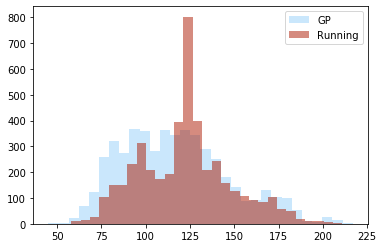

<IPython.core.display.Javascript object>

In [5]:
# Get rid of zeros because they represent either incomplete or erroneous data.
gen_filtered = gen[gen["tempo"] != 0]
run_filtered = running[running["tempo"] != 0]
gen_filtered["tempo"].hist(bins=30, alpha=0.5, label="GP", color=gen_bar_color)
run_filtered["tempo"].hist(bins=30, alpha=0.5, label="Running", color=run_bar_color)
plt.legend()
plt.grid(b=None)
plt.show()

There's an obvious spike around 125 in the running playlist data. Let's run a quick test for normality before continuing on to a t-test

In [6]:
print(stats.describe(gen_filtered["tempo"]))
print(stats.describe(run_filtered["tempo"]))

DescribeResult(nobs=4995, minmax=(44.978, 216.843), mean=117.0567075075075, variance=923.1977151100659, skewness=0.5126162414952244, kurtosis=-0.2153056072706594)
DescribeResult(nobs=4454, minmax=(57.967, 216.334), mean=122.51974449932646, variance=659.8384563128767, skewness=0.33999720681387696, kurtosis=0.09191662790906507)


<IPython.core.display.Javascript object>

In [7]:
_, p = stats.ttest_ind(gen_filtered["tempo"], run_filtered["tempo"])
print(p)

8.304645583849454e-21


<IPython.core.display.Javascript object>

The t-test comes out with a pretty definitive p value of ~ $8.3 * {10}^{-21}$

A 95% confidence interval will give us a good idea of how different they really are.

In [8]:
l, h = get_95_ci(run_filtered["tempo"], gen_filtered["tempo"])

low = gen_filtered["tempo"].mean() + l
high = gen_filtered["tempo"].mean() + h

(low, high)
l, h

print(
    f"The confidence interval returns a range of {round(l, 2)} and {round(h, 2)} beats per minute higher than the population average"
)

print(
    f"This give a range of {round(low,1)} and {round(high, 1)} BPM when compared to the average of the population"
)

The confidence interval returns a range of 4.33 and 6.59 beats per minute higher than the population average
This give a range of 121.4 and 123.7 BPM when compared to the average of the population


<IPython.core.display.Javascript object>

The range of 121.4 to 123.7 gives us a good ballpark of where the middle is at least in relation to the overall population. However, now that we have established there is in fact a difference, I think a more poignant bit of data would be looking at the summary of only the running playlist songs.

Not only is the average among running songs higher, the range is significantly narrower as well.

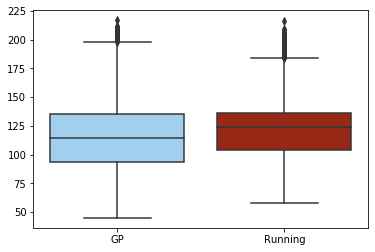

<IPython.core.display.Javascript object>

In [12]:
gen_temp = pd.DataFrame(data=gen_filtered["tempo"])
gen_temp = gen_temp.rename(columns={"tempo": "gen"})
run_temp = pd.DataFrame(run_filtered["tempo"])
run_temp = run_temp.rename(columns={"tempo": "run"})

box_df_tempo = pd.concat([gen_temp, run_temp], axis=1)

bp = sns.boxplot(data=box_df_tempo, palette=[gen_bar_color, run_bar_color])
bp.set_xticklabels(("GP", "Running"))
plt.show()

In [39]:
gm = gen_filtered["tempo"].mean()
gs = gen_filtered["tempo"].std()
rm = run_filtered["tempo"].mean()
rs = run_filtered["tempo"].std()

print(
    f"The range of BPM as defined by the mean({round(rm,1)}) +/- standard deviation is {round(rm-rs, 1)} to {round(rm+rs, 1)}"
)

The range of BPM as defined by the mean(122.5) +/- standard deviation is 96.8 to 148.2


<IPython.core.display.Javascript object>

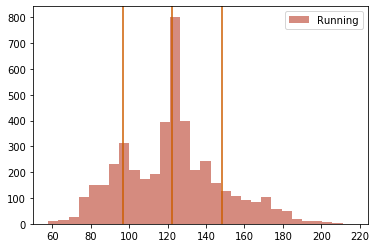

<IPython.core.display.Javascript object>

In [40]:
# gen_filtered = gen[gen["tempo"] != 0]
run_filtered = running[running["tempo"] != 0]
# gen_filtered["tempo"].hist(bins=30, alpha=0.5, label="GP", color=gen_bar_color)
run_filtered["tempo"].hist(bins=30, alpha=0.5, label="Running", color=run_bar_color)

# put lines at the mean and +- standard deviation

# plt.axvline(x=gm, color=gen_line_color)
# plt.axvline(x=gm + gs, color=gen_line_color)
# plt.axvline(x=gm - gs, color=gen_line_color)

plt.axvline(x=rm, color=run_line_color)
plt.axvline(x=rm + rs, color=run_line_color)
plt.axvline(x=rm - rs, color=run_line_color)

plt.legend()
plt.grid(b=None)
plt.show()

96.8 to 148.2 is too wide of a range and seems to include some possibly unfavorable BPMs

In [37]:
print(
    f'The range given as a function of IQR is {round(run_filtered["tempo"].describe()["25%"],1)} to {round(run_filtered["tempo"].describe()["75%"],1)} '
)

The range given as a function of IQR is 104.0 to 136.0 


<IPython.core.display.Javascript object>

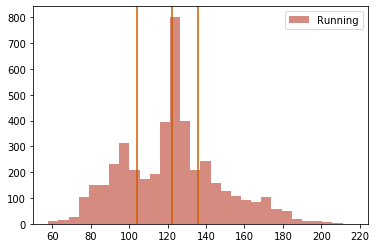

<IPython.core.display.Javascript object>

In [41]:
# gen_filtered = gen[gen["tempo"] != 0]
run_filtered = running[running["tempo"] != 0]
# gen_filtered["tempo"].hist(bins=30, alpha=0.5, label="GP", color=gen_bar_color)
run_filtered["tempo"].hist(bins=30, alpha=0.5, label="Running", color=run_bar_color)

# put lines at the mean and +- standard deviation

# plt.axvline(x=gm, color=gen_line_color)
# plt.axvline(x=gm + gs, color=gen_line_color)
# plt.axvline(x=gm - gs, color=gen_line_color)

plt.axvline(x=rm, color=run_line_color)
plt.axvline(x=run_filtered["tempo"].describe()["25%"], color=run_line_color)
plt.axvline(x=run_filtered["tempo"].describe()["75%"], color=run_line_color)

plt.legend()
plt.grid(b=None)
plt.show()

A BPM between 104 and 136 could be deemed acceptable, but considering the density around the mean, I think it would be wise to stick as close to 122 BPM as possible.

---------
In the context of our initial assumption about wanting faster songs in our running playlists, we are able to reject the null and confirm our belief. However, on the whole, running songs are only 4 to 7 BPM higher. Upon looking at purely the running songs, we are able to create a safe range with an emphasis on sticking close to the mean of 122.

Looking back to our initial checklist, we can cross fast off with a note to optimal BPM.

- [x] Fast (122 BPM)
- [ ] Energetic
- [ ] Uplifting

Moving on to "Energetic" we'll be looking at the "energy" metric [which is defined](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) as such:
>Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

103.977

<IPython.core.display.Javascript object>